In [1]:
# Import pandas and plotting packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split, GridSearchCV,KFold, cross_val_score
from sklearn.metrics import r2_score,f1_score, confusion_matrix, classification_report, accuracy_score, roc_auc_score, mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder

# recursive feature elimination (RFE)
from sklearn.feature_selection import RFE, RFECV

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV


In [2]:
# Read in the data and print out the .head()
NewLoanDF = pd.read_csv("NewLoanData.csv")
NewLoanDF.head()

,Income,Age,Experience,Risk Flag,Married/Single,Home Ownership,Car Ownership
0,1303834,23,3,0,0,0,0
1,7574516,40,10,0,0,0,0
2,3991815,66,4,0,1,0,0
3,6256451,41,2,1,0,0,1
4,5768871,47,11,1,0,0,0


## Split data into test and training

In [36]:
#define X and y
X = NewLoanDF.drop('Risk Flag',axis=1)
y = NewLoanDF['Risk Flag']

In [45]:
#Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify= y, random_state=42)

In [46]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (201600, 6)
X_test shape: (50400, 6)


In [47]:
print ('Number of observations in the target variable before oversampling of the minority class:', np.bincount (y_train) )

Number of observations in the target variable before oversampling of the minority class: [176803  24797]


Text(0.5, 1.0, 'Dataset before SMOTE')

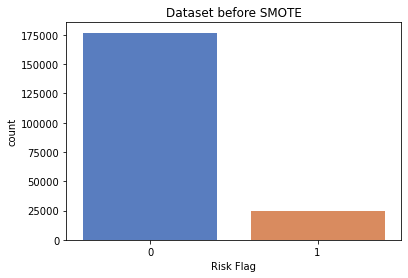

In [48]:
ax=sns.countplot(x = y_train, palette = 'muted')
ax.set_title('Dataset before SMOTE')

In [49]:
# What is the default rate in training and test sets?
print(f"Training default rate is {y_train.mean():.2%}")
print(f"Test default rate is     {y_test.mean():.2%}")

Training default rate is 12.30%
Test default rate is     12.30%


In [50]:
from imblearn.over_sampling import SMOTE

print ('Number of observations in the target variable before oversampling of the minority class:', np.bincount (y_train) )

smt = SMOTE ()
X_train, y_train = smt.fit_resample (X_train, y_train)

print ('\nNumber of observations in the target variable after oversampling of the minority class:', np.bincount (y_train) )

Number of observations in the target variable before oversampling of the minority class: [176803  24797]

Number of observations in the target variable after oversampling of the minority class: [176803 176803]


Text(0.5, 1.0, 'Dataset after oversampling')

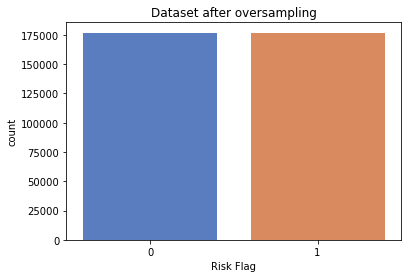

In [43]:
ax=sns.countplot(x = y_train, palette = 'muted')
ax.set_title('Dataset after oversampling')

In [51]:
# What is the default rate in training and test sets?
print(f"Training default rate is {y_train.mean():.2%}")
print(f"Test default rate is     {y_test.mean():.2%}")

Training default rate is 50.00%
Test default rate is     12.30%


In [52]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
353601    1
353602    1
353603    1
353604    1
353605    1
Name: Risk Flag, Length: 353606, dtype: int64

## Predict using Decision Tree Classifier

In [11]:
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier()
dct.fit(X_train,y_train)
dct_predict = dct.predict(X_test)

In [12]:
print(f'Accuracy Score: {accuracy_score (y_test, dct_predict):.2f}')
print(f'AUC Score: {roc_auc_score (y_test, dct_predict):.2f}')
print(f'F1 Score: {f1_score(y_test,dct_predict):.2f}')

Accuracy Score: 0.86
AUC Score: 0.86
F1 Score: 0.60


In [13]:
#DecisionTree gives us a 0.88 accuracy and a .75 auc score

<AxesSubplot:>

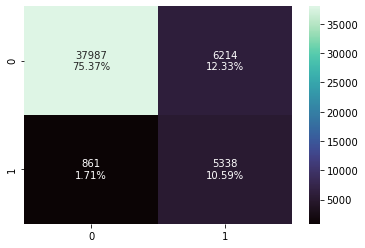

In [14]:
dct_cfm = confusion_matrix(y_test,dct_predict)

group_counts = ['{0:0.0f}'.format(value) for value in
                dct_cfm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     dct_cfm.flatten()/np.sum(dct_cfm)]
labels = [f'{v2}\n{v3}' for  v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(dct_cfm, annot=labels, fmt='', cmap='mako')

In [15]:
print(classification_report(y_test, dct.predict(X_test), 
                           target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.98      0.86      0.91     44201
         Yes       0.46      0.86      0.60      6199

    accuracy                           0.86     50400
   macro avg       0.72      0.86      0.76     50400
weighted avg       0.91      0.86      0.88     50400



In [16]:
# RFE 
dct = DecisionTreeClassifier()
rfe = RFE(dct, n_features_to_select=1)

X_rfe = rfe.fit_transform(X_train, y_train)
dct.fit(X_rfe, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True False False False False False]
[1 2 3 4 6 5]


In [17]:
# I should be able to print out variables and rank order
print("Input Variables Sorted by Their Rank:")

# Create an empty dictionary
d = {}
for i in range(len(rfe.ranking_)):
    d[rfe.ranking_[i]] = X.columns[i]

#print(d)
print(sorted(d.items()))

Input Variables Sorted by Their Rank:
[(1, 'Income'), (2, 'Age'), (3, 'Experience'), (4, 'Married/Single'), (5, 'Car Ownership'), (6, 'Home Ownership')]


In [18]:
X.describe()

,Income,Age,Experience,Married/Single,Home Ownership,Car Ownership
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,0.102095,0.051262,0.301587
std,2.878311e+06,17.063855,6.002590,0.302774,0.220532,0.458948
min,1.031000e+04,21.000000,0.000000,0.000000,0.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,0.000000,0.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,0.000000,0.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,0.000000,0.000000,1.000000
max,9.999938e+06,79.000000,20.000000,1.000000,1.000000,1.000000


## Predict using Log Regression

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_predict = lr.predict(X_test)

In [20]:
print(f'Accuracy Score: {accuracy_score (y_test, lr_predict):.2f}')
print(f'AUC Score: {roc_auc_score (y_test, lr_predict):.2f}')
print(f'F1 Score: {f1_score(y_test,lr_predict):.2f}')

Accuracy Score: 0.50
AUC Score: 0.53
F1 Score: 0.22


In [21]:
#LogisticRegression give us 0.88 accuracy and 0.5 auc score

<AxesSubplot:>

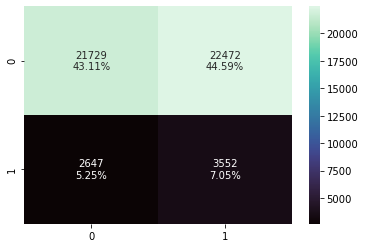

In [22]:
lr_cfm = confusion_matrix(y_test,lr_predict)

group_counts = ['{0:0.0f}'.format(value) for value in
                lr_cfm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     lr_cfm.flatten()/np.sum(lr_cfm)]
labels = [f'{v2}\n{v3}' for  v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_cfm, annot=labels, fmt='', cmap='mako')

In [23]:
print(classification_report(y_test, lr.predict(X_test), 
                           target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.89      0.49      0.63     44201
         Yes       0.14      0.57      0.22      6199

    accuracy                           0.50     50400
   macro avg       0.51      0.53      0.43     50400
weighted avg       0.80      0.50      0.58     50400



## Predict using KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predict= knn.predict(X_test)

In [25]:
print(f'Accuracy Score: {accuracy_score (y_test, knn_predict):.2f}')
print(f'AUC Score: {roc_auc_score (y_test, knn_predict):.2f}')
print(f'F1 Score: {f1_score(y_test,knn_predict):.2f}')

Accuracy Score: 0.86
AUC Score: 0.75
F1 Score: 0.51


In [26]:
#KNN give us 0.89 accuracy and 0.71 auc score and f1 0.51

<AxesSubplot:>

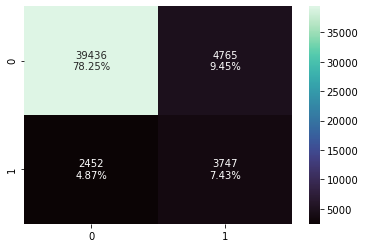

In [27]:
knn_cfm = confusion_matrix(y_test,knn_predict)

group_counts = ['{0:0.0f}'.format(value) for value in
                knn_cfm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     knn_cfm.flatten()/np.sum(knn_cfm)]
labels = [f'{v2}\n{v3}' for  v2, v3 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(knn_cfm, annot=labels, fmt='', cmap='mako')

In [28]:
print(classification_report(y_test, knn.predict(X_test), 
                           target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.94      0.89      0.92     44201
         Yes       0.44      0.60      0.51      6199

    accuracy                           0.86     50400
   macro avg       0.69      0.75      0.71     50400
weighted avg       0.88      0.86      0.87     50400



## Predict using 

In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)

In [30]:
print(f'Accuracy Score: {accuracy_score (y_test, rfc_predict):.2f}')
print(f'AUC Score: {roc_auc_score (y_test, rfc_predict):.2f}')
print(f'F1 Score: {f1_score(y_test,rfc_predict):.2f}')

Accuracy Score: 0.86
AUC Score: 0.86
F1 Score: 0.60


## Trying some FOLDS


In [31]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [32]:
folds = 5
reg = LogisticRegression()
cvAUC = cross_val_score(reg, X, y, cv=folds, scoring="roc_auc")
cvAcc = cross_val_score(reg, X, y, cv=folds, scoring="accuracy")

print(cvAUC)

[0.50513364 0.50125179 0.50485306 0.50235594 0.49995095]


In [33]:
print(cvAcc)

[0.87700397 0.87700397 0.87700397 0.87700397 0.87698413]
